# Assignment 5 : Deep learning
<br>Last updated on 11/02/2023</br>


credit : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainvalset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


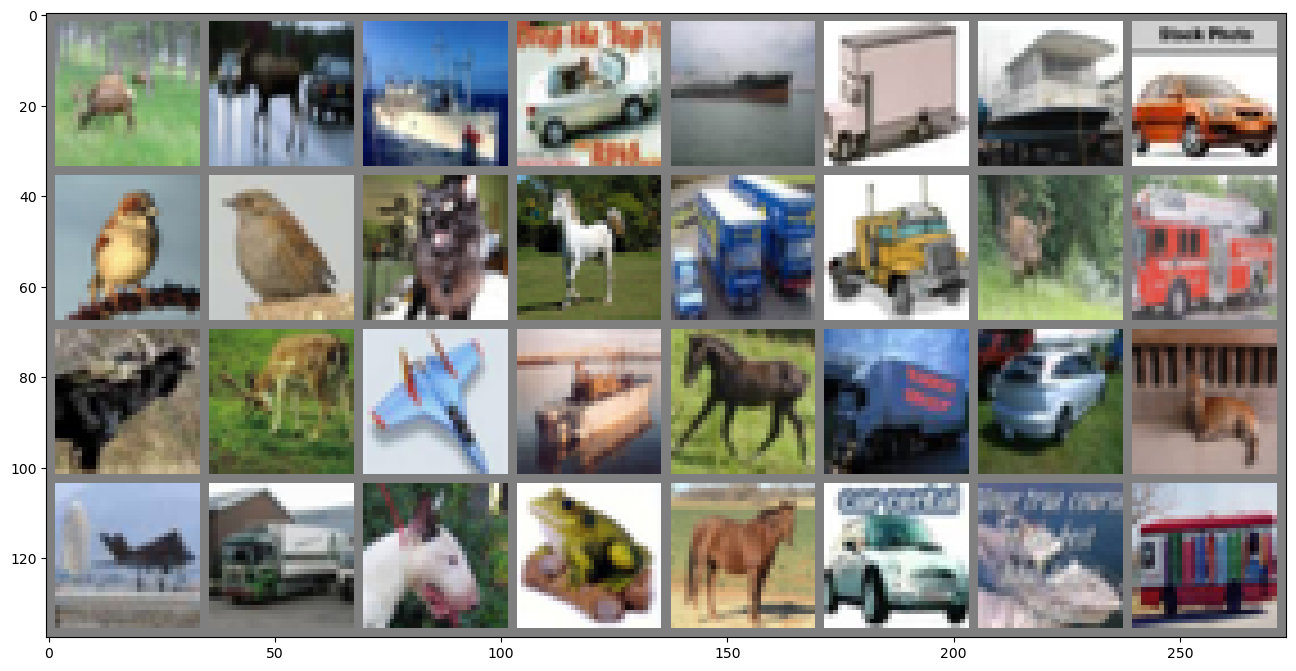

deer  deer  ship  car   ship  truck ship  car   bird  bird  cat   horse truck truck deer  truck deer  deer  plane ship  horse truck car   deer  plane truck dog   frog  horse car   ship  truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


# Model1: NN

Create a model to have an image of 32*32 pixels as an input with 10 output classes.

The model composes of flatten, dropout 20%, dense with 128 neurons, and output layer (with softmax) to classify each image into 10 classes.
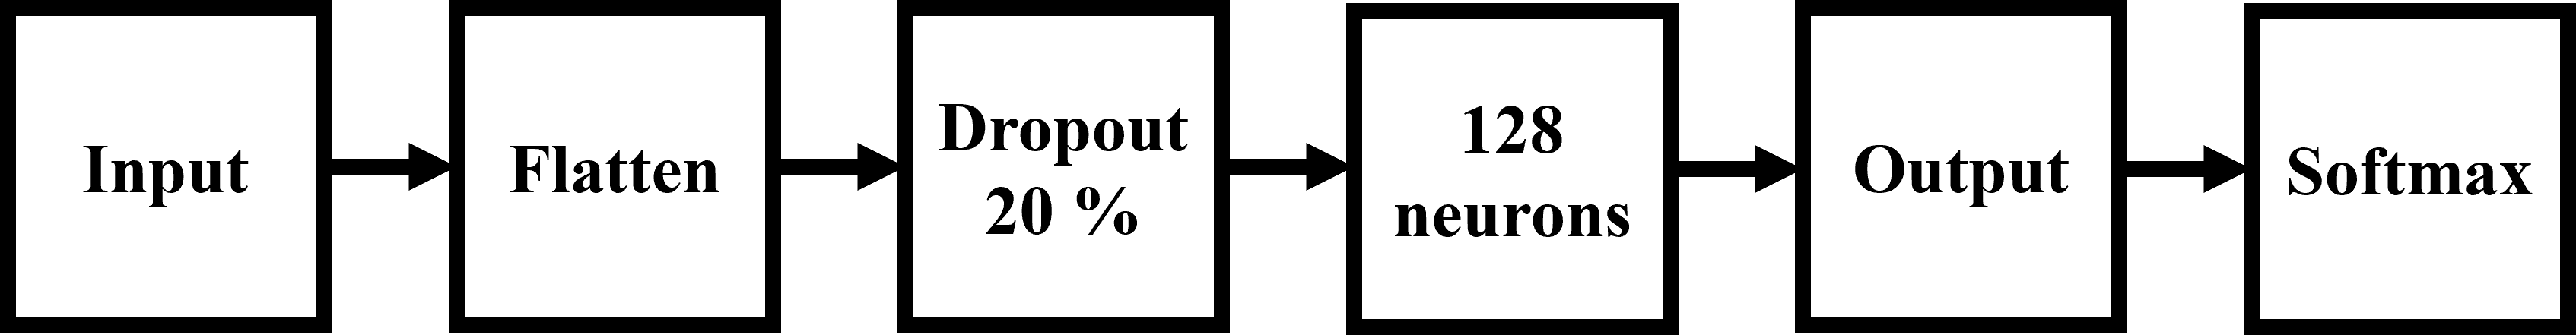

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(3072, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.flatten(x,start_dim=1) 
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

net = Net().to(device)

Optimizer and criterion

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Training Model

In [8]:
PATH = './cifar_net.pth'
min_val_loss = 1e10
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    running_val_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
            
    avg_loss = running_loss/len(trainloader)
    net.eval()
    with torch.no_grad():
        for i,data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
        avg_val_loss = running_val_loss/len(valloader)

    if avg_val_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = avg_val_loss
        print(f"Best model was saved at Epoch {epoch}")

print('Finished Training')
torch.save(net.state_dict(), PATH)

Best model was saved at Epoch 0
Best model was saved at Epoch 1
Best model was saved at Epoch 2
Best model was saved at Epoch 3
Best model was saved at Epoch 4
Best model was saved at Epoch 8
Best model was saved at Epoch 9
Finished Training


In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [10]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
min_val_loss

2.0076335421004616

Evaluation 

In [12]:
predict = list()
label = list()
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        
        label += list(labels.cpu().numpy())
        predict += list(outputs.argmax(dim=1).cpu().numpy())
        
print("Classification report")
report = classification_report(label, predict,digits=4)
print(report)

Classification report
              precision    recall  f1-score   support

           0     0.6377    0.3520    0.4536      1000
           1     0.5012    0.6380    0.5614      1000
           2     0.4000    0.2380    0.2984      1000
           3     0.3490    0.2230    0.2721      1000
           4     0.3749    0.4150    0.3939      1000
           5     0.3680    0.3640    0.3660      1000
           6     0.4542    0.6100    0.5207      1000
           7     0.4416    0.5330    0.4830      1000
           8     0.4850    0.7100    0.5763      1000
           9     0.5415    0.4500    0.4915      1000

    accuracy                         0.4533     10000
   macro avg     0.4553    0.4533    0.4417     10000
weighted avg     0.4553    0.4533    0.4417     10000



# Model2: CNN

Modify Model1:

Before the flatten layer, add 2 layers of Conv2D with kernel(2*2) for 32 and 64 filters with relu activation, respectively.
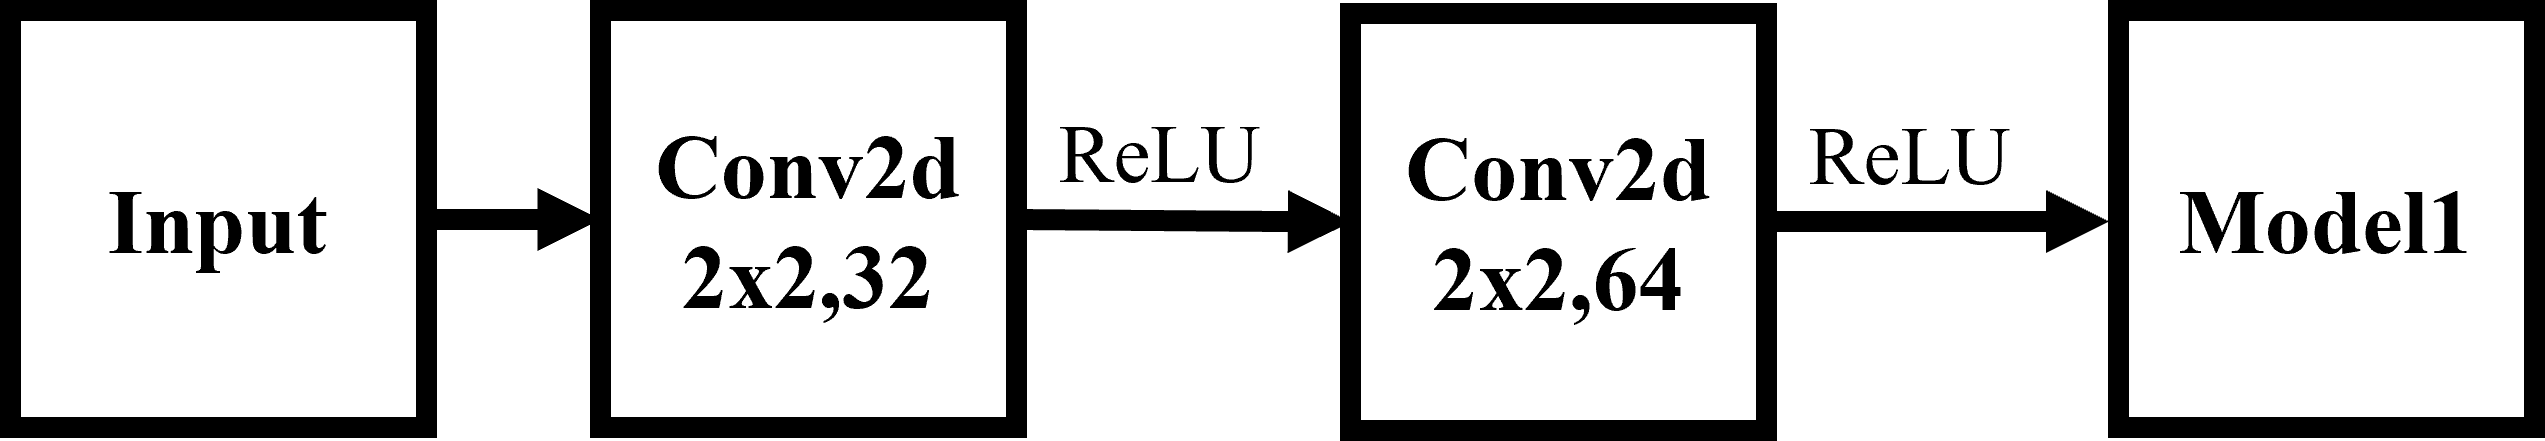

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 2) 
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(14400, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x,start_dim=1) 
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

net = CNN1().to(device)

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [28]:
PATH = './cifar_CNN1.pth'
min_val_loss = 1e10
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    running_val_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
        
    avg_loss = running_loss/len(trainloader)
    net.eval()
    with torch.no_grad():
        for i,data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

        avg_val_loss = running_val_loss/len(valloader)

    if avg_val_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = avg_val_loss
        print(f"Best model was saved at Epoch {epoch}")

print('Finished Training')
torch.save(net.state_dict(), PATH)

Best model was saved at Epoch 0
Best model was saved at Epoch 1
Best model was saved at Epoch 2
Best model was saved at Epoch 3
Best model was saved at Epoch 4
Best model was saved at Epoch 5
Best model was saved at Epoch 7
Best model was saved at Epoch 8
Best model was saved at Epoch 9
Finished Training


In [16]:
net = CNN1()
net.load_state_dict(torch.load(PATH))
net.to(device)

CNN1(
  (conv1): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(2, 2), stride=(1, 1))
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=14400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [17]:
predict = list()
label = list()
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        label += list(labels.cpu().numpy())
        predict += list(outputs.argmax(dim=1).cpu().numpy())

print("Classification report")
report = classification_report(label, predict,digits=4)
print(report)

Classification report
              precision    recall  f1-score   support

           0     0.6200    0.6070    0.6134      1000
           1     0.7667    0.6080    0.6782      1000
           2     0.4674    0.4510    0.4590      1000
           3     0.3938    0.4840    0.4343      1000
           4     0.4822    0.5270    0.5036      1000
           5     0.4928    0.4760    0.4842      1000
           6     0.6894    0.5770    0.6282      1000
           7     0.6157    0.6440    0.6295      1000
           8     0.6470    0.7680    0.7023      1000
           9     0.6818    0.6170    0.6478      1000

    accuracy                         0.5759     10000
   macro avg     0.5857    0.5759    0.5781     10000
weighted avg     0.5857    0.5759    0.5781     10000



# Model3: CNN with max-pool & dropout

Modify Model2:

After Conv2D layers in Model2, add MaxPooling2D with pooling size (2*2) and then dropout 30%.
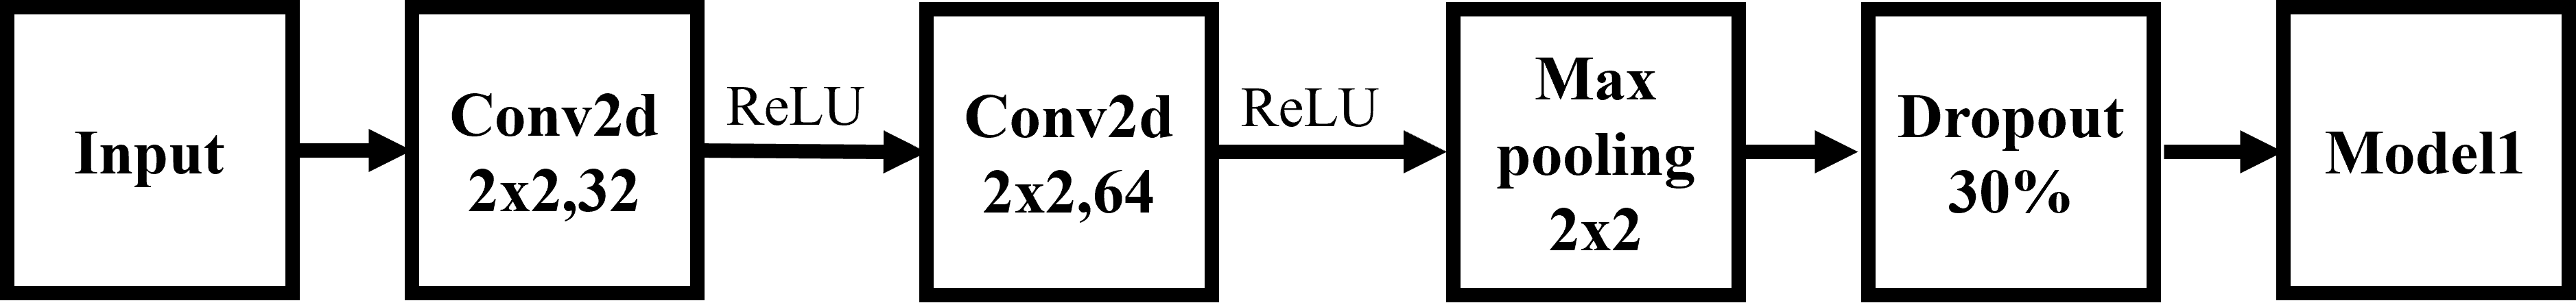

In [33]:
import torch.nn as nn
import torch.nn.functional as F


class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 2) 
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)
        x = torch.flatten(x,start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    
net = CNN2().to(device)

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [31]:
PATH = './cifar_CNN2.pth'
min_val_loss = 1e10
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    running_val_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
        
    avg_loss = running_loss/len(trainloader)
    net.eval()
    with torch.no_grad():
        for i,data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

        avg_val_loss = running_val_loss/len(valloader)

    if avg_val_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = avg_val_loss
        print(f"Best model was saved at Epoch {epoch}")

print('Finished Training')
torch.save(net.state_dict(), PATH)

torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
torch.Size([32, 16, 7, 7])
t

KeyboardInterrupt: 

In [21]:
net = CNN2()
net.load_state_dict(torch.load(PATH))
net.to(device)

CNN2(
  (conv1): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [22]:
predict = list()
label = list()
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        label += list(labels.cpu().numpy())
        predict += list(outputs.argmax(dim=1).cpu().numpy())

print("Classification report")
report = classification_report(label, predict,digits=4)
print(report)

Classification report
              precision    recall  f1-score   support

           0     0.6332    0.5920    0.6119      1000
           1     0.7574    0.6150    0.6788      1000
           2     0.4278    0.4530    0.4400      1000
           3     0.4236    0.4460    0.4345      1000
           4     0.4982    0.5470    0.5214      1000
           5     0.6132    0.3520    0.4473      1000
           6     0.6583    0.6590    0.6587      1000
           7     0.7080    0.5480    0.6178      1000
           8     0.5330    0.8550    0.6567      1000
           9     0.5872    0.6400    0.6124      1000

    accuracy                         0.5707     10000
   macro avg     0.5840    0.5707    0.5680     10000
weighted avg     0.5840    0.5707    0.5680     10000

